# Le problème

Pour garantir l'équilibre offre-demande à chaque instant, RTE construit ses propres prévisions de la consommation nationale, régionale, et locale. 
Nous nous concentrons ici sur la prévision nationale. Un challenge lancé par RTE (https://www.datascience.net/fr/challenge/33/details) a permis de tester des approches alternatives aux modèles internes (POPCORN, PREMIS)
Un tout nouveau* data challenge vient d'être lancé sur la plateforme dataScience.net pour aider RTE a faire de meilleures prévisions de conso ! 


## Un outil: le Machine Learning
Pour cela nous allons avoir recours au Machine Learning. Cela nous permettra de créer un modèle qui apprend et s'adapte au contexte sans programmer un système expert avec des "centaines" de règles en dur par de la programmation logique. Le Machine Learning nécessite toutefois de la connaissance experte dans le domaine d'intérêt pour créer des modèles pertinents et efficaces. En effet, si notre modèle embarque trop de variables peu explicatives, il sera noyé dans l'information, surapprendra sur les exemples qu'on lui a montrés, et aura du mal à généraliser en prédisant avec justesse sur de nouveaux exemples. 

## Une difficulté: le feature engineering
Au-delà de la simple sélection de variables pertinentes, on fait surtout ce que l'on appelle du feature engineering avec notre expertise: on créé des variables transformées ou aggrégées, comme une consommation moyenne sur le mois précédent ou une température moyenne sur la France, pour guider l'algorithme à apprendre sur l'information la plus pertinente et synthétique.
Cela suppose de bien connaître nos données, de les traiter et de les visualiser avec différents algorithmes au préalable.

Nous allons ici voir ce que cela implique en terme de développement et d'implémentation de participer à un tel challenge, en montrant les capacités du Machine Learning sur la base de modèles "classiques", et aussi leurs limites.

## Ce que l'on va voir dans ce premier TP :
1) Formaliser le problème: que souhaite-t-on prédire (quel est mon Y) ? Avec quelles variables explicatives (quel est mon X) ?

2) Collecter les données: où se trouvent les données ? Quel est le format ? Comment les récupérer ? (FACULTATIF)

3) Investiguer les données: visualiser des séries temporelles, faire quelques statistiques descriptives

4) Préparer les données: pour entrainer et tester un premier modèle

5) Créer et entrainer un premier modèle simple: ce sera notre baseline

6) Evaluer un modèle

7) Itérer en créant de nouveaux modèles avec de nouvelles variables explicatives

8) Jouez: créer vos propres modèles, tester sur une saison différente, tester sur une région différente, faire une prévision avec incertitudes, détecter des outliers

## To be continued
Le deuxième TP permettra d'investiguer les modèles "Deep" avec réseaux de neurones, en montrant le moindre besoin en feature engineering et leur plus grande capacité a absorber l'information de par les représentations hiérarchiques qu'ils se créent.

# Dimensionnement en temps
On prévoit un une durée d'environ 2h pour ce TP1, debrief inclus :
- 20-30 minutes pour charger et préparer les données
- 30-40 minutes pour analyser et visualiser les données
- 45-60 minutes pour créer, entrainer, évaluer et interpréter les modèles

# Se familiariser avec le problème: Eco2mix
Quand on parle de courbe de consommation France, il y a une application incontournable : eco2mix !
Allons voir à quoi ressemblent ces courbes de consommation, pour nous faire une idée du problème et se donner quelques intuitions:
http://www.rte-france.com/fr/eco2mix/eco2mix
ou sur application mobile

## Chargement des Librairies

In [66]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip install ma_librairie'
import os  # accès aux commandes système
import datetime  # structure de données pour gérer des objets calendaires
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
import matplotlib.pyplot as plt  # tracer des visualisations
import sklearn  # librairie de machine learning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

from fbprophet import Prophet  # un package de series temporelles mis a disposition par facebook
import urllib3  # scrapper le web
import shutil  # move ou copier fichier
import zipfile  # compresser ou décompresser fichier

# Pour visualisation sur une carte utilsons la librairie bokeh qui fait appel a une api GoogleMaps
from bokeh.palettes import inferno
from bokeh.io import show, output_notebook
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, PanTool, WheelZoomTool, BoxSelectTool, ColorBar, LogTicker,
    LabelSet, Label,HoverTool
)
from collections import OrderedDict
import seaborn as sns
from bokeh.models.mappers import LogColorMapper

%matplotlib inline

ModuleNotFoundError: No module named 'fbprophet'

# Configuration
Choix du répertoire de travail "data_folder" dans lequel tous les fichiers csv seront entreposés

In [67]:
data_folder = os.path.join(os.getcwd(),"data")
%autosave 0

Autosave disabled


In [68]:
# Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : D:\Users\dordonnatvir\Documents\FIFA\TP_Formation_Conso_MachineLearning\data
Fichiers contenus dans ce répertoire :
 - communes_coordonnees.csv
 - eCO2mix_RTE_tempo_2017-2018.xls
 - eCO2mix_RTE_tempo_2017-2018.zip
 - joursFeries.csv
 - meteoX_T0_T24.zip
 - StationsMeteoRTE.csv
 - Xinput.csv
 - Yconso.csv
 - YconsoT0


# Récupération des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python.
Les données brutes ont été pré-traitées à l'aide du notebook TP1_Preparation_donnees :
- Yconso.csv
- Xinput.csv

In [69]:
Yconso = pd.read_csv("data/Yconso.csv")

Yconso['ds'] = pd.to_datetime(Yconso['ds'])

print(Yconso.head(5))
print(Yconso.shape)


                   ds      y
0 2012-12-28 00:00:00  59679
1 2012-12-28 01:00:00  55354
2 2012-12-28 02:00:00  54324
3 2012-12-28 03:00:00  52066
4 2012-12-28 04:00:00  49684
(39049, 2)


In [70]:
Xinput = pd.read_csv("data/Xinput.csv")
Xinput['ds'] = pd.to_datetime(Xinput['ds'])

print(Xinput.head(5))
print(Xinput.shape)

                   ds  X002Th+24  X005Th+24  X015Th+24  X027Th+24  X070Th+24  \
0 2012-12-28 00:00:00        NaN        NaN        NaN        NaN        NaN   
1 2012-12-28 01:00:00        NaN        NaN        NaN        NaN        NaN   
2 2012-12-28 02:00:00        NaN        NaN        NaN        NaN        NaN   
3 2012-12-28 03:00:00        NaN        NaN        NaN        NaN        NaN   
4 2012-12-28 04:00:00        NaN        NaN        NaN        NaN        NaN   

   X110Th+24  X120Th+24  X130Th+24  X145Th+24     ...       X621Th+24  \
0        NaN        NaN        NaN        NaN     ...             NaN   
1        NaN        NaN        NaN        NaN     ...             NaN   
2        NaN        NaN        NaN        NaN     ...             NaN   
3        NaN        NaN        NaN        NaN     ...             NaN   
4        NaN        NaN        NaN        NaN     ...             NaN   

   X630Th+24  X643Th+24  X645Th+24  X650Th+24  X675Th+24  X690Th+24  \
0        

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour se faire, il est utile de se faire quelques stats descriptives et des visualisations pour nos différentes variables.

Traitant d'un problème de prévisions, on visualisera en particulier des séries temporelles.

Vous allez voir:
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisation de corrélation entre conso J et conso retardée
- visualisations des stations météos
- visualisations des séries temporelles des températures
- calcul de corrélation sur la température entre les différentes stations météo

## Calcul de statistiques descriptives sur la consommation nationale
A l'aide de la fonction _describe_.

In [71]:
Yconso['y'].describe()

count    39049.000000
mean     54777.694461
std      12024.918519
min      29477.000000
25%      45638.000000
50%      53201.000000
75%      63222.000000
max      94190.000000
Name: y, dtype: float64

## Visualiser la consommation d'un jour particulier
On souhaite visualiser la consommation réalisée pour un jour donné de l'historique.

In [72]:
def plot_load(var_load, year, month, day):
    date_cible = datetime.datetime(year=year, month=month, day=day)  # implicitement heure = minuit
    date_lendemain_cible = date_cible + datetime.timedelta(days=1)
    mask = (var_load.ds >= date_cible) & (var_load.ds <= date_lendemain_cible)   
    consoJour = var_load[mask]
    plt.plot(consoJour['ds'], consoJour['y'], color='blue')
    plt.show()

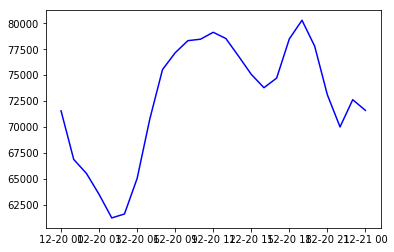

In [73]:
plot_load(Yconso, 2016, 12, 20)

## Afficher une semaine arbitraire de consommation
On pourra modifier la fonction précédente en rajoutant le timedelta en paramètre.

In [74]:
def plot_load_timedelta(var_load, year, month, day, delta_days):
    date_cible = datetime.datetime(year=year, month=month, day=day)
    date_lendemain_cible = date_cible + datetime.timedelta(days=delta_days)

    conso_periode = var_load[(var_load.ds >= date_cible) 
                                      & (var_load.ds <= date_lendemain_cible)]
    plt.plot(conso_periode['ds'], conso_periode['y'], color='blue')
    plt.show()

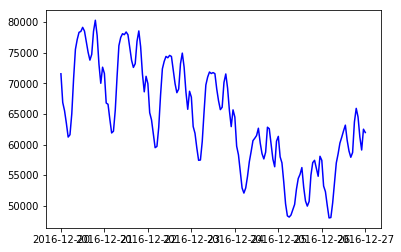

In [75]:
plot_load_timedelta(Yconso, 2016, 12, 20, delta_days=7)

## Observation des profils de la consommation pour les mois d'hiver et les mois d'été
Toujours dans le but d'appréhender nos données, on va regarder les profils moyens pour le smois d'été et pour ceux d'hiver. On va également observer le min et le max pour avoir une idée de la variabilité du signal.

In [76]:
# Par commodité, on isole le mois pour après attraper les mois d'hiver et d'été
Xinput['month'] = Xinput['ds'].dt.month

# On isole aussi les heures
Xinput['hour'] = Xinput['ds'].dt.hour

# On sépare les jours de la semaine en week-end / pas week-end
# De base, la fonction datetime.weekday() renvoie 0 => Lundi, 2 => Mardi, ..., 5 => Samedi, 6 => Dimanche
# Ci-dessous, si on a un jour d ela semaine alors dans la colonne weekday on mettra 1, et 0 si c'est le week-end
Xinput['weekday'] = (Xinput['ds'].dt.weekday < 5).astype(int)  # conversion bool => int

In [77]:
Xinput.head(5)

,ds,X002Th+24,X005Th+24,X015Th+24,X027Th+24,X070Th+24,X110Th+24,X120Th+24,X130Th+24,X145Th+24,...,X645Th+24,X650Th+24,X675Th+24,X690Th+24,X747Th+24,holiday,FranceTh+24,month,hour,weekday
0,2012-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,0,1
1,2012-12-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1,1
2,2012-12-28 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,1
3,2012-12-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,3,1
4,2012-12-28 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4,1


In [78]:
# On aggrège les mois d'hiver ensemble
XY_df = pd.merge(Yconso, Xinput, on = 'ds')
groupedHiver = XY_df[(XY_df.month == 12) | 
                                     (XY_df.month == 1) | 
                                     (XY_df.month == 2)].groupby(['weekday', 'hour'], as_index=True)

# Idem pour les mois d'été
groupedEte = XY_df[(XY_df.month == 6) | 
                                   (XY_df.month == 7) | 
                                   (XY_df.month == 8)].groupby(['weekday', 'hour'], as_index=True)

statsHiver = groupedHiver['y'].aggregate([np.mean, np.min, np.max])
statsEte = groupedEte['y'].aggregate([np.mean, np.min, np.max])

In [79]:
print(statsHiver)

                      mean   amin   amax
weekday hour                            
0       0     67983.416667  52914  84086
        1     63497.350000  48866  79809
        2     62439.141667  47963  79855
        3     59820.758333  45759  77323
        4     57227.808333  43833  74709
        5     56318.225000  43520  74306
        6     57280.483333  44858  75671
        7     58994.008333  46444  77925
        8     60924.033333  48324  81365
        9     63016.475000  49467  83759
        10    65326.583333  51791  85443
        11    66056.308333  52786  84508
        12    66815.241667  53317  83312
        13    67815.641667  54316  84065
        14    64132.591667  50394  81236
        15    61574.633333  47892  79046
        16    60116.833333  46704  77601
        17    60404.666667  47935  77260
        18    64754.725000  50872  80222
        19    69327.783333  57047  85419
        20    68657.383333  56500  84433
        21    65902.341667  54213  80210
        22    63

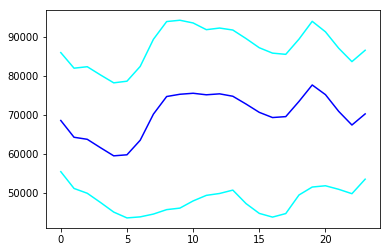

In [80]:
# On affiche des infos sur le profil pour les jours de la semaine
semaine = statsHiver.loc[1]  # 0 pour les jours de semaine
weekend = statsHiver.loc[0]  # 0 pour weekend

plt.plot(semaine['amin'], color='cyan')
plt.plot(semaine['mean'], color='blue')
plt.plot(semaine['amax'], color='cyan')
plt.show()

## Lien avec la consommation passée
A l'aide de la fonction shift, pour un point horaire cible on regarde  :
- la consommation de l'heure précédente, 
- du jour précédent, 
- de la semaine précédente.

On regarde ensuite si la consommation réalisé peut se deviner à partir de ces observations.

In [81]:
Xinput['lag1H'] = Yconso['y'].shift(1)
Xinput['lag1D'] = Yconso['y'].shift(24)
Xinput['lag1W'] = Yconso['y'].shift(24*7)

In [82]:
Xinput.head(24 * 7 + 1)

,ds,X002Th+24,X005Th+24,X015Th+24,X027Th+24,X070Th+24,X110Th+24,X120Th+24,X130Th+24,X145Th+24,...,X690Th+24,X747Th+24,holiday,FranceTh+24,month,hour,weekday,lag1H,lag1D,lag1W
0,2012-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,0,1,NaN,NaN,NaN
1,2012-12-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,1,1,59679.0,NaN,NaN
2,2012-12-28 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,2,1,55354.0,NaN,NaN
3,2012-12-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,3,1,54324.0,NaN,NaN
4,2012-12-28 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,4,1,52066.0,NaN,NaN
5,2012-12-28 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,5,1,49684.0,NaN,NaN
6,2012-12-28 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,6,1,49511.0,NaN,NaN
7,2012-12-28 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,7,1,51782.0,NaN,NaN
8,2012-12-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,8,1,55374.0,NaN,NaN
9,2012-12-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12,9,1,59087.0,NaN,NaN


On regarde maintenant graphiquement si on a une belle corrélation ou non :

In [83]:
def plot_scatter_load(var_x):
    plt.scatter(Xinput[var_x],Yconso['y'])
    plt.title(var_x)
    plt.show()

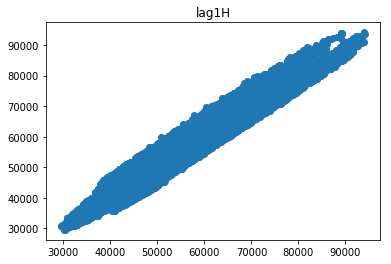

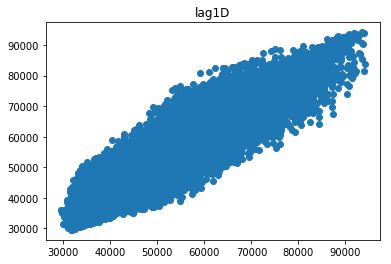

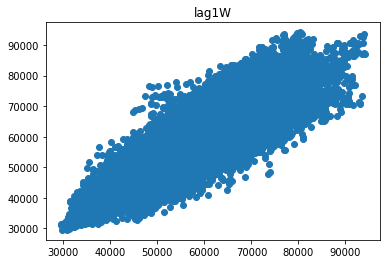

In [84]:
plot_scatter_load('lag1H')
plot_scatter_load('lag1D')
plot_scatter_load('lag1W')

### Question
Que pensez-vous de ces corrélations ?

## Visualisation des stations météo

Regardons si les températures des stations météo sont corrélées entre elles :

In [85]:
#matrix_correlation = meteo_obs_df.corr() #calcul d'une corrélation globale
cols = list(Xinput.columns[Xinput.columns.str.endswith("Th+24")])
#calcul de la corrélation en fonction de la saison

Xinput['saison'] = ((Xinput['ds'].dt.month ==1) |(Xinput['ds'].dt.month==2)|(Xinput['ds'].dt.month==12)).astype(int)*1+((Xinput['ds'].dt.month ==3 )|(Xinput['ds'].dt.month==4)|(Xinput['ds'].dt.month==5)).astype(int)*2+((Xinput['ds'].dt.month ==6 )|(Xinput['ds'].dt.month==7)|(Xinput['ds'].dt.month==8)).astype(int)*3+((Xinput['ds'].dt.month ==9) |(Xinput['ds'].dt.month==10)|(Xinput['ds'].dt.month==11)).astype(int)*4  # conversion bool => int
matrix_correlation = Xinput[['saison'] + cols].groupby(['saison']).corr() 
matrix_correlation

FranceTh+24  X002Th+24  X005Th+24  X015Th+24  X027Th+24  \
saison                                                                        
1      FranceTh+24     1.000000   0.824177   0.890486   0.601741   0.882208   
       X002Th+24       0.824177   1.000000   0.931137   0.666200   0.870747   
       X005Th+24       0.890486   0.931137   1.000000   0.637226   0.914269   
       X015Th+24       0.601741   0.666200   0.637226   1.000000   0.557301   
       X027Th+24       0.882208   0.870747   0.914269   0.557301   1.000000   
       X070Th+24       0.913440   0.856282   0.906043   0.633452   0.837783   
       X110Th+24       0.748138   0.746856   0.777088   0.453298   0.857488   
       X120Th+24       0.809495   0.824079   0.833560   0.518492   0.932394   
       X130Th+24       0.874720   0.786769   0.839354   0.502902   0.947696   
       X145Th+24       0.893981   0.824033   0.875162   0.671862   0.842537   
       X149Th+24       0.941327   0.835807   0.912966   0.599586   0.879157   
       X156Th+24       0.941137   0.873385   0.935223   0.594914   0.886598   
       X168Th+24       0.929758   0.781046   0.873389   0.538969   0.817110   
       X180Th+24       0.888519   0.779414   0.821815   0.564717   0.757051   
       X190Th+24       0.805059   0.693084   0.736423   0.466641   0.671662   
       X222Th+24       0.907864   0.765129   0.842074   0.489795   0.911709   
       X240Th+24       0.947799   0.779793   0.866064   0.513211   0.886771   
       X255Th+24       0.942063   0.723650   0.806045   0.478348   0.805829   
       X260Th+24       0.923538   0.689423   0.774045   0.455629   0.770939   
       X280Th+24       0.877935   0.660740   0.746322   0.462591   0.688895   
       X299Th+24       0.862622   0.677369   0.734975   0.470142   0.685059   
       X434Th+24       0.860737   0.691124   0.704599   0.440548   0.704766   
       X460Th+24       0.873626   0.630618   0.689521   0.395184   0.690938   
       X481Th+24       0.851842   0.623242   0.693209   0.395741   0.643797   
       X497Th+24       0.720666   0.474034   0.533912   0.306569   0.545866   
       X510Th+24       0.875353   0.596658   0.679744   0.372293   0.716262   
       X579Th+24       0.866525   0.598751   0.671251   0.413658   0.650252   
       X588Th+24       0.787654   0.490581   0.585668   0.334200   0.590723   
       X621Th+24       0.808313   0.520325   0.604838   0.321201   0.641055   
       X630Th+24       0.843584   0.559205   0.621057   0.374600   0.640349   
...                         ...        ...        ...        ...        ...   
4      X110Th+24       0.888799   0.831235   0.878243   0.853589   0.926208   
       X120Th+24       0.917773   0.875129   0.913198   0.893212   0.960651   
       X130Th+24       0.949012   0.865242   0.924544   0.906727   0.971333   
       X145Th+24       0.977482   0.931600   0.972056   0.969998   0.958969   
       X149Th+24       0.979892   0.922739   0.968686   0.970807   0.954530   
       X156Th+24       0.973676   0.946148   0.970820   0.973954   0.946534   
       X168Th+24       0.974929   0.880694   0.941534   0.947913   0.930988   
       X180Th+24       0.957922   0.879527   0.921431   0.938596   0.890665   
       X190Th+24       0.947844   0.864317   0.904343   0.922288   0.876426   
       X222Th+24       0.957151   0.856288   0.916656   0.901937   0.955169   
       X240Th+24       0.983347   0.891565   0.943627   0.936489   0.955756   
       X255Th+24       0.985712   0.875842   0.926077   0.925570   0.929400   
       X260Th+24       0.975110   0.839657   0.910489   0.909974   0.919019   
       X280Th+24       0.970085   0.866505   0.906179   0.915158   0.889092   
       X299Th+24       0.953320   0.849596   0.895844   0.908427   0.876818   
       X434Th+24       0.962227   0.849190   0.886614   0.881373   0.891755   
       X460Th+24       0.969020   0.838127   0.890712   0.889163   0.892214   
       X481Th+24       0.958089   0.851897   0.880411   0.888834   0.8

D:\Users\dordonnatvir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


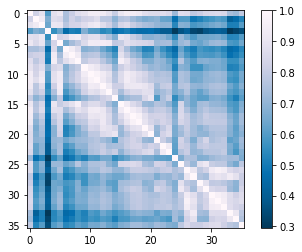

In [86]:
#heatMap pour un meilleur visuel
#.loc[1]=hiver
#.loc[2]=printemps
#.loc[3]=été
#.loc[4]=automne
plt.imshow(matrix_correlation.loc[1].as_matrix(),cmap='PuBu_r', interpolation='nearest')
plt.colorbar()
plt.show()

### Question
- Que pensez-vous de ces corrélations ?

## Visualiser la consommation en fonction de la température de la station Paris-Montsouris
On voudrait savoir si la consommation nationale peut s'expliquer en regardant simplement la température de la station du Parc Montsouris et en ignorant ce qui est extérieur au périphérique (Paris étant le centre du monde). Pour cela, on peut tracer un nuage de points.

NB : Paris Montsouris est la station météo n°156


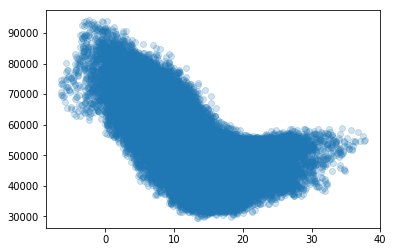

In [87]:
plt.scatter(Xinput['X156Th+24'], Yconso['y'], alpha=0.2)
plt.show()

### Question
- Que pensez-vous de ce nuage ? Est-ce suffisant ?

## Bricolage d'un modèle prédictif naïf

<img src="pictures/hommeNaif.png" width=500 height=60>

In [88]:
datetime_a_predire = datetime.datetime.strptime("2016-12-20_14:00", "%Y-%m-%d_%H:%M")

y_true = float(Yconso.loc[Yconso['ds'] == datetime_a_predire]['y'])

print("On veut predire la consommation du {}, soit {}".format(datetime_a_predire, y_true))

On veut predire la consommation du 2016-12-20 14:00:00, soit 76823.0


## Première idée, un modèle naïf : pour l'heure qui nous intéresse, on plaque bêtement la valeur de consommation nationale de la veille

In [89]:
datetime_la_veille = datetime_a_predire - datetime.timedelta(days=1)
y_pred = float(Yconso.loc[Yconso['ds'] == datetime_la_veille]['y'])
pred_error = abs(y_true - y_pred)

print("Modele 1 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred, y_true, pred_error/y_true * 100))

Modele 1 -- pred: 78134.0, realisee: 76823.0, erreur: 1.7065201827577678%


## Deuxième idée avec de l'expertise : pareil, avec comme raffinement le fait que l'on considere maintenant l'influence de la temperature

<img src="pictures/ExpertJamy.jpg" width=500 height=60>

In [90]:
delta_MW_par_degre = 2400  # par expertise, 
                           # on considere qu'une augmentation moyenne de 1°C 
                           # conduit à une augmentation de 2400MW de la conso nationale

In [91]:
# Pour faire simple, on va prétendre que ce qui se passe à Paris 
# est représentatif de ce qu'il se passe en France comme delta de température
# Paris-Montsouris est la station numéro 156

temperature_Montsouris_veille = float(Xinput.loc[Xinput['ds'] == datetime_la_veille]['X156Th+24'])
temperature_Montsouris_cible = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['X156Th+24'])
delta_temp = temperature_Montsouris_cible - temperature_Montsouris_veille

delta_MW_because_temp = delta_temp * delta_MW_par_degre

In [92]:
y_pred = float(Yconso.loc[Yconso['ds'] == datetime_la_veille]['y']) + delta_MW_because_temp
pred_error = abs(y_true - y_pred)

print("Modele 2 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred, y_true, pred_error/y_true * 100))

Modele 2 -- pred: 74534.0, realisee: 76823.0, erreur: 2.979576428934043%


Bon... Bien essayé mais maintenant on va être plus sérieux !

# Préparer un jeu d'entrainement et un jeu de test
En machine learning, il y a 2 types d'erreur que l'on peut calculer : l'erreur d'entrainement et l'erreur de test. 

Pour évaluer la capacité de notre modèle à bien généraliser sur de nouvelles données, il est très important de se préserver un jeu de test indépendant de celui d'entrainement.

Il faut donc segmenter notre dataset en 2 : 
- un premier jeu servira pour l'entrainement, 
- tandis que le second servira à mesurer les performances du modèle prédictif.

In [93]:
def prepareDataSetEntrainementTest(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0):
    
    dateStart = Xinput.iloc[0]['ds']
    
    DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur)+' days')  #si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
    XinputTest = Xinput[(Xinput.ds >= dateRupture)]    

    XinputTrain=Xinput[(Xinput.ds < dateRupture) & (Xinput.ds > DateStartWithLag) & (Xinput.ds > dateDebut)]
    YconsoTrain=Yconso[(Yconso.ds < dateRupture) & (Yconso.ds > DateStartWithLag) & (Yconso.ds > dateDebut)]
    YconsoTest=Yconso[(Xinput.ds >= dateRupture)]
    
    return XinputTrain, XinputTest, YconsoTrain, YconsoTest

In [94]:
# on souhaite un jeu de test qui commence à partir du 1er mai 2017
dateDebut = datetime.datetime(year=2013, month=1, day=7)#pour éviter les NaN dans le jeu de données
dateRupture = datetime.datetime(year=2017, month=5, day=1)#début du challenge prevision de conso

# On va commencer par un modèle autoregressif très simple, ici X=Y
# Pas de prise en compte de la météo, des variables calendaires, etc...
# Attention, on conserve dans un autre objet la matrice des variables exogènes
Xinput_save = Xinput
Xinput = Yconso 
nbJourlagRegresseur = 0  # pas de prise en compte des consommations passées pour l'instant

In [95]:
XinputTrain, XinputTest, YconsoTrain, YconsoTest = prepareDataSetEntrainementTest(Xinput, Yconso, 
                                                                                  dateDebut, dateRupture, 
                                                                                  nbJourlagRegresseur)

In [96]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape))
print('la taille de l échantillon XinputTest est:' + str(XinputTest.shape))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape))
print('la taille de l échantillon YconsoTest est:' + str(YconsoTest.shape))
print("la proportion de data d'entrainement est de:" + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] + YconsoTest.shape[0])))

la taille de l échantillon XinputTrain est:(37798, 2)
la taille de l échantillon XinputTest est:(1010, 2)
la taille de l échantillon YconsoTrain est:(37798, 2)
la taille de l échantillon YconsoTest est:(1010, 2)
la proportion de data d'entrainement est de:0.9739744382601525


# Fonctions utilitaires

Créons la fonction modelError qui va calculer pour un échantillon (Y, Y_hat) différents scores :
- erreur relative moyenne (MAPE en %)
- erreur relative max (en %)
- rmse (en MW)


In [97]:
def modelError(Y, Yhat):

    Y = Y.reset_index(drop=True)
    
    relativeErrorsTest = np.abs((Y['y'] - Yhat) /Y['y']) 
    errorMean = np.mean(relativeErrorsTest)
    errorMax = np.max(relativeErrorsTest)
    rmse = np.sqrt(mean_squared_error(Y['y'], Yhat))
   
    return relativeErrorsTest, errorMean, errorMax, rmse

In [98]:
def evaluation(YTrain, YTest, YTrainHat, YTestHat):
    # Ytrain et Ytest ont deux colonnes : ds et y
    # YtrainHat et YTestHat sont des vecteurs
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTest, YTestHat)
    print("l'erreur relative moyenne de test est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de test est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0)))
    print()
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTrain, YTrainHat)
    print("l'erreur relative moyenne de train est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de train est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0))) 

In [99]:
def evaluation_par(X, Y, Yhat,avecJF=True):
    Y['weekday'] = Y['ds'].dt.weekday
    Y['hour'] = Y['ds'].dt.hour
    if(avecJF):
        Y['JoursFeries'] = X['JoursFeries']
    Y['APE'] = np.abs(Y['y']-Yhat)/Y['y']
    dataWD = Y[['weekday','APE']]
    groupedWD = dataWD.groupby(['weekday'], as_index=True)
    statsWD = groupedWD.aggregate([np.mean])
    dataHour = Y[['hour','APE']]
    groupedHour = dataHour.groupby(['hour'], as_index=True)
    statsHour = groupedHour.aggregate([np.mean])
    
    if(avecJF):
        dataJF=Y[['JoursFeries','APE']]
        groupedJF = dataJF.groupby(['JoursFeries'], as_index=True)
        statsJF = groupedJF.aggregate([np.mean])
    else:
        statsJF=None
    
    return statsWD,statsHour,statsJF

In [100]:
Xinput.head()

,ds,y
0,2012-12-28 00:00:00,59679
1,2012-12-28 01:00:00,55354
2,2012-12-28 02:00:00,54324
3,2012-12-28 03:00:00,52066
4,2012-12-28 04:00:00,49684


# Créer un modèle avec Prophet
Vous allez utiliser la librairie Prophet developpée par facebook.: https://research.fb.com/prophet-forecasting-at-scale/. Elle a été publiée en 2017 et permet de faire des modèles de prévision sur des séries temporelles. En particulier, ces modèles captent surtout des saisonnalités, et peuvent également tenir compte de jours particuliers comme les jours fériés. Il est possible de rajouter d'autre variables explicatives selon un modèle statistique linéaire.

C'est une librairie relativement ergonomique et performante en terme de temps de calculs d'où son choix ici.
Un des aspects intéressant également est qu'elle repose sur un language probabiliste PyStan. Il est ainsi possible de décrire des variables selon une loi dans notre modèle et d'obtenir sans plus de développement des intervalles de confiance et incertitudes.

Pour un tutoriel bien fait pour comprendre et utiliser Prophet, je vous recommande le lien suivant: http://www.degeneratestate.org/posts/2017/Jul/24/making-a-prophet/

La prophétie autoréalisatrice: Marc Zuckerberg futur Président ..??

<img src="pictures/zuckerbergProphet.jpg" width=500 height=30>

In [56]:
# creer un modèle prophet avec une saisonnalité journalière et une tendance nulle pour la consommation
mTrain = Prophet(daily_seasonality=True, n_changepoints=0)  # on considere une tendance relativement constante pour la consommation sur les 4 ans

NameError: name 'Prophet' is not defined

## Entrainer un modèle
Notre modèle a des paramètres tels que les saisonnalités qu'il va falloir maintenant apprendre au vu de notre jeu d'entrainement. Il faut donc caler notre modèle sur ce jeu d'entrainement.

In [130]:
mTrain.fit(XinputTrain)

/home/antomaro/.local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Faire des prédictions
Une fois qu'un modèle de prévision est entrainé, il ne s'avère utile que s'il est performant sur de nouvelles situations. Faisons une prévision sur notre jeu de test.

In [131]:
forecastTest = mTrain.predict(XinputTest)
forecastTrain = mTrain.predict(XinputTrain)

/usr/lib/python3.5/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/usr/lib/python3.5/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


on plot a partir de la date:2017-04-01 00:00:00


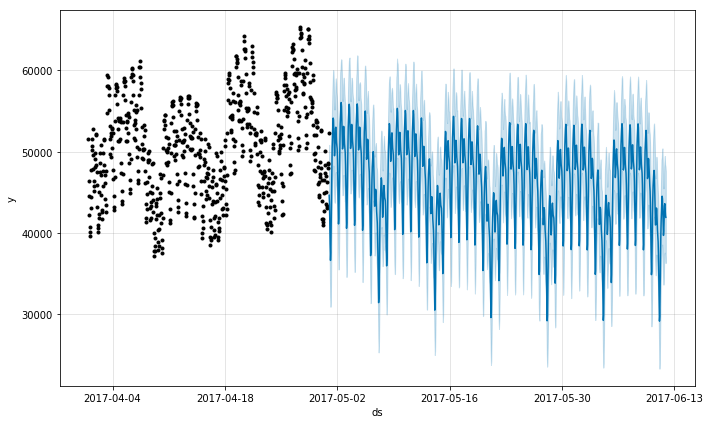

In [132]:
# on visualise nos previsions avec incertitudes
dateavantRupture = dateRupture - pd.Timedelta('30 days')  # pour visualiser aussi les réalisations d'avant

print('on plot a partir de la date:' + str(dateavantRupture))
mTrain.history = mTrain.history[mTrain.history.ds >= dateavantRupture]  # pour demander à Prophet de ne plotter que notre période d'interet
mTrain.plot(forecastTest)

plt.show()

## Visualiser le modèle
Prophet dispose de méthodes de visualisation qui permettent d'interpreter le modèle appris, en particulier d'un point de vue des saisonalités.

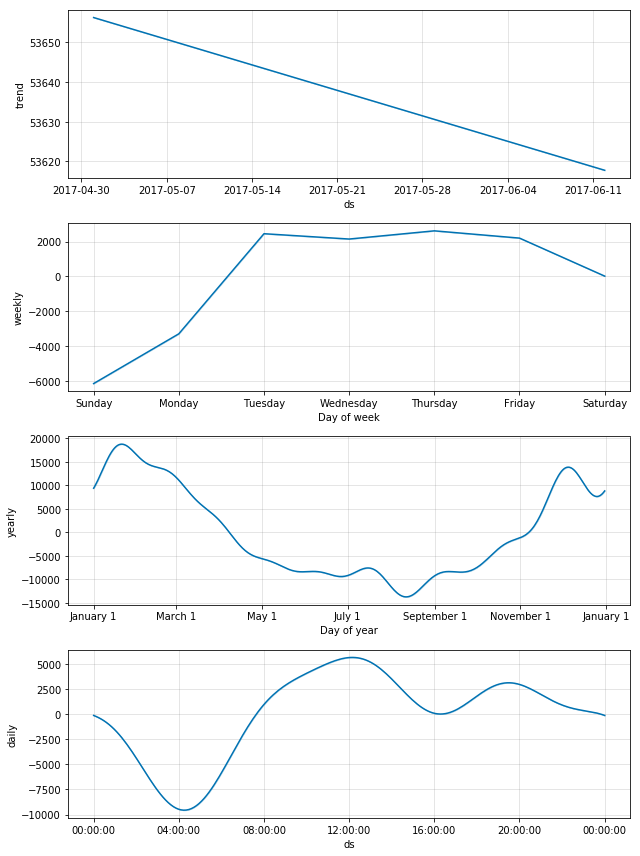

In [133]:
# on visualise notre modele avec ses saisonalites
mTrain.plot_components(forecastTest)

plt.show()

## Interpreter le modèle 
Au vu des visualisations précédentes :
- quelles interprétations pouvez-vous faire du modèle?
- Comment varie le comportement de la courbe de consommation?

In [134]:
#avecJF=False#on n a pas encore considere de jours feries
#evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest['yhat'],avecJF)
#print(str(round(evalWD*100,1)))
#print(str(round(evalHour*100,1)))
#print(str(round(evalJF*100,1)))

## Evaluer l'erreur de prévision
Au vu de ces previsions faites par notre modèle sur de nouvelles situations, quelle est la performance de notre modèle sur ce jeu de test ?

In [135]:
evaluation(YconsoTrain, YconsoTest, forecastTrain['yhat'], forecastTest['yhat'])

l'erreur relative moyenne de test est de:5.8%
l'erreur relative max de test est de:31.6%
le rmse de test est de:3296.0

l'erreur relative moyenne de train est de:6.3%
l'erreur relative max de train est de:44.5%
le rmse de test est de:4591.0


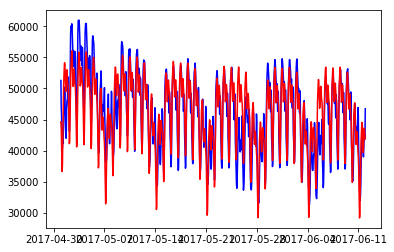

In [136]:
# on visualise nos previsions par rapport a la realité
plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b')
plt.plot(forecastTest['ds'], forecastTest['yhat'], 'r')
plt.show()

## Enquêter autour des erreurs de prévision

### Evaluation en fonction du jour de semaine, de l'heure, si jour férié ou non

### Comment se distribue l'erreur ?

In [137]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(YconsoTest, forecastTest['yhat'])

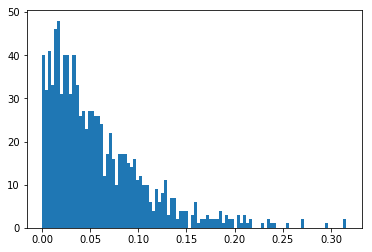

In [138]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

### A quel moment se trompe-t-on le plus ?

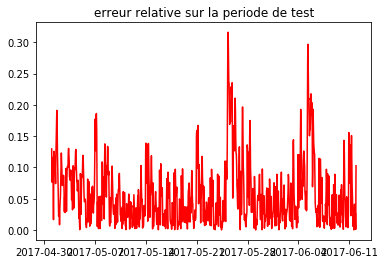

In [139]:
plt.plot(forecastTest['ds'], erreur_relative_test, 'r')
plt.title("erreur relative sur la periode de test")
plt.show()

In [140]:
threshold = 0.18

mask = (erreur_relative_test >= threshold)
forecastTest['ds'].loc[mask]

17    2017-05-01 17:00:00
18    2017-05-01 18:00:00
147   2017-05-07 03:00:00
148   2017-05-07 04:00:00
582   2017-05-25 06:00:00
583   2017-05-25 07:00:00
584   2017-05-25 08:00:00
585   2017-05-25 09:00:00
586   2017-05-25 10:00:00
587   2017-05-25 11:00:00
588   2017-05-25 12:00:00
590   2017-05-25 14:00:00
593   2017-05-25 17:00:00
594   2017-05-25 18:00:00
595   2017-05-25 19:00:00
596   2017-05-25 20:00:00
597   2017-05-25 21:00:00
606   2017-05-26 06:00:00
607   2017-05-26 07:00:00
608   2017-05-26 08:00:00
631   2017-05-27 07:00:00
632   2017-05-27 08:00:00
824   2017-06-04 08:00:00
846   2017-06-05 06:00:00
847   2017-06-05 07:00:00
848   2017-06-05 08:00:00
849   2017-06-05 09:00:00
850   2017-06-05 10:00:00
851   2017-06-05 11:00:00
857   2017-06-05 17:00:00
858   2017-06-05 18:00:00
859   2017-06-05 19:00:00
860   2017-06-05 20:00:00
861   2017-06-05 21:00:00
865   2017-06-06 01:00:00
Name: ds, dtype: datetime64[ns]

## Feature engineering
Quelles variables explicatives peuvent nous permettre de créer un modele plus perfomant ?

# On quitte Prophet pour d'autres modèles : RandomForest et XGBoost

## Preparation de Xinput

In [116]:
Xinput = Xinput_save
Xinput = Xinput.drop(['lag1H'],axis=1)  # on supprime la consommation retardée d'une heure, non disponible pour notre exercice de prévision

In [117]:
print(Xinput.shape)
print(Xinput.columns)

(39049, 44)
Index(['ds', 'X002Th+24', 'X005Th+24', 'X015Th+24', 'X027Th+24', 'X070Th+24',
       'X110Th+24', 'X120Th+24', 'X130Th+24', 'X145Th+24', 'X149Th+24',
       'X156Th+24', 'X168Th+24', 'X180Th+24', 'X190Th+24', 'X222Th+24',
       'X240Th+24', 'X255Th+24', 'X260Th+24', 'X280Th+24', 'X299Th+24',
       'X434Th+24', 'X460Th+24', 'X481Th+24', 'X497Th+24', 'X510Th+24',
       'X579Th+24', 'X588Th+24', 'X621Th+24', 'X630Th+24', 'X643Th+24',
       'X645Th+24', 'X650Th+24', 'X675Th+24', 'X690Th+24', 'X747Th+24',
       'holiday', 'FranceTh+24', 'month', 'hour', 'weekday', 'lag1D', 'lag1W',
       'saison'],
      dtype='object')


On encode les données calendaires en one-hot encoding pour le modèle.
Cet encodage est nécessaire pour que le modèle mathématique puisse appréhender la notion de date.

In [118]:
encodedWeekDay = pd.get_dummies(Xinput['weekday'],prefix="weekday")
encodedMonth = pd.get_dummies(Xinput['month'],prefix="month")
encodedHour = pd.get_dummies(Xinput['hour'],prefix="hour")

In [119]:
encodedWeekDay.head(3)

,weekday_0,weekday_1
0,0,1
1,0,1
2,0,1


In [120]:
encodedMonth.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1


In [121]:
encodedHour.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
Xinput = pd.concat([Xinput, encodedMonth, encodedWeekDay, encodedHour], axis=1)
Xinput = Xinput.drop(['month','weekday','hour','saison'],axis=1)

In [123]:
print(Xinput.shape)
print(Xinput.columns)

(39049, 78)
Index(['ds', 'X002Th+24', 'X005Th+24', 'X015Th+24', 'X027Th+24', 'X070Th+24',
       'X110Th+24', 'X120Th+24', 'X130Th+24', 'X145Th+24', 'X149Th+24',
       'X156Th+24', 'X168Th+24', 'X180Th+24', 'X190Th+24', 'X222Th+24',
       'X240Th+24', 'X255Th+24', 'X260Th+24', 'X280Th+24', 'X299Th+24',
       'X434Th+24', 'X460Th+24', 'X481Th+24', 'X497Th+24', 'X510Th+24',
       'X579Th+24', 'X588Th+24', 'X621Th+24', 'X630Th+24', 'X643Th+24',
       'X645Th+24', 'X650Th+24', 'X675Th+24', 'X690Th+24', 'X747Th+24',
       'holiday', 'FranceTh+24', 'lag1D', 'lag1W', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'ho

In [124]:
# Récupération des prévisions météo à J+1 pour la veille
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th+24' in s]
lag_colsToKeepWeather = [ s + "_J_1" for s in colsToKeepWeather ]
Xinput[lag_colsToKeepWeather] = Xinput[colsToKeepWeather].shift(24)
time = pd.to_datetime(Xinput['ds'], yearfirst=True)
Xinput['posan']= time.dt.dayofyear

In [125]:
#Récupération des jours fériés dans Xinput
encodedHolidays = pd.get_dummies(Xinput[['holiday']], prefix = "JF")
encodedHolidays['JoursFeries'] = encodedHolidays.sum(axis = 1)
Xinput = pd.concat([Xinput, encodedHolidays], axis = 1)
Xinput = Xinput.drop(['holiday'], axis = 1)

In [126]:
#affichage de toutes les variables de base
list(Xinput) #list plutôt que print pour avoir la liste complète

['ds',
 'X002Th+24',
 'X005Th+24',
 'X015Th+24',
 'X027Th+24',
 'X070Th+24',
 'X110Th+24',
 'X120Th+24',
 'X130Th+24',
 'X145Th+24',
 'X149Th+24',
 'X156Th+24',
 'X168Th+24',
 'X180Th+24',
 'X190Th+24',
 'X222Th+24',
 'X240Th+24',
 'X255Th+24',
 'X260Th+24',
 'X280Th+24',
 'X299Th+24',
 'X434Th+24',
 'X460Th+24',
 'X481Th+24',
 'X497Th+24',
 'X510Th+24',
 'X579Th+24',
 'X588Th+24',
 'X621Th+24',
 'X630Th+24',
 'X643Th+24',
 'X645Th+24',
 'X650Th+24',
 'X675Th+24',
 'X690Th+24',
 'X747Th+24',
 'FranceTh+24',
 'lag1D',
 'lag1W',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'X002Th+24_J_

In [157]:
XinputTrain, XinputTest, YconsoTrain, YconsoTest = prepareDataSetEntrainementTest(Xinput, 
                                                                                  Yconso, 
                                                                                  dateDebut, 
                                                                                  dateRupture, 
                                                                                  nbJourlagRegresseur)

In [158]:
print('shape de XinputTrain est:' + str(XinputTrain.shape[0]))
print('shape de XinputTest est:' + str(XinputTest.shape[0]))
print('shape de YconsoTrain est:' + str(YconsoTrain.shape[0]))
print('shape de YconsoTest est:' + str(YconsoTest.shape[0]))
print('la proportion de data d entrainement est de:' + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] + YconsoTest.shape[0])))

shape de XinputTrain est:37798
shape de XinputTest est:1010
shape de YconsoTrain est:37798
shape de YconsoTest est:1010
la proportion de data d entrainement est de:0.9739744382601525


## Modèle RandomForest

<img src="pictures/randomForestExplain.png" width=500 height=30>

In [159]:
from sklearn.ensemble import RandomForestRegressor

### Préparation des données d'entrée

In [160]:
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th+24' in s]
colsToKeepMonth = [v for v in Xinput.columns.get_values() if 'month' in v]
colsToKeepWeekday = [v for v in Xinput.columns.get_values() if 'weekday' in v]
colsToKeepHour = [v for v in Xinput.columns.get_values() if 'hour' in v]
colsToKeepHolidays = [v for v in Xinput.columns.get_values() if 'JF_' in v]

colsRF = np.concatenate((['lag1D','lag1W','JoursFeries'],
                         colsToKeepWeather,colsToKeepMonth,colsToKeepWeekday,colsToKeepHour))

### Entrainement du modèle

In [161]:
# La cellule peut prendre un peu de temps à exécuter
rfTrain = RandomForestRegressor(n_estimators=30, max_features=colsRF.size, n_jobs=3)
rfTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=113, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=3,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Prediction

In [162]:
forecastTest = rfTrain.predict(XinputTest[colsRF])
forecastTrain = rfTrain.predict(XinputTrain[colsRF])

### Evaluation

l'erreur relative moyenne de test est de:3.8%
l'erreur relative max de test est de:31.9%
le rmse de test est de:2512.0

l'erreur relative moyenne de train est de:0.9%
l'erreur relative max de train est de:17.8%
le rmse de test est de:767.0


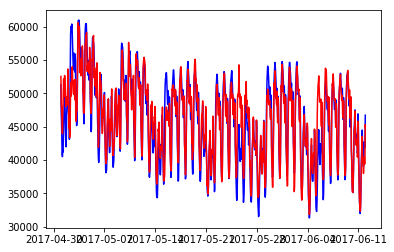

In [163]:
evaluation(YconsoTrain, YconsoTest, forecastTrain, forecastTest)

# on visualise nos previsions par rapport a la realité
plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

In [164]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


         APE
        mean
weekday     
0        7.0
1        3.8
2        2.2
3        4.4
4        3.3
5        3.0
6        2.8
      APE
     mean
hour     
0     2.5
1     2.3
2     2.5
3     2.7
4     3.8
5     4.1
6     5.0
7     6.5
8     6.6
9     5.4
10    4.4
11    4.1
12    3.3
13    3.2
14    4.1
15    4.5
16    3.8
17    3.9
18    3.7
19    3.4
20    3.1
21    3.2
22    2.2
23    2.2
             APE
            mean
JoursFeries     
0            3.8
1            2.1


## Modèle xgboost

<img src="pictures/XGboost.png" width=500 height=30>

In [165]:
import xgboost as xgb

In [166]:
xgbTrain = xgb.XGBRegressor( )
xgbTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])
forecastTestXGB = xgbTrain.predict(XinputTest[colsRF])
forecastTrainXGB = xgbTrain.predict(XinputTrain[colsRF])

In [167]:
evaluation(YconsoTrain, YconsoTest, forecastTrainXGB, forecastTestXGB)

l'erreur relative moyenne de test est de:3.9%
l'erreur relative max de test est de:30.8%
le rmse de test est de:2614.0

l'erreur relative moyenne de train est de:3.1%
l'erreur relative max de train est de:38.1%
le rmse de test est de:2401.0


In [168]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTestXGB)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

         APE
        mean
weekday     
0        7.1
1        2.9
2        2.2
3        5.5
4        4.3
5        2.6
6        2.7
      APE
     mean
hour     
0     2.6
1     2.8
2     3.1
3     3.4
4     3.5
5     3.8
6     4.9
7     5.9
8     6.2
9     5.4
10    4.7
11    3.9
12    3.4
13    3.1
14    4.0
15    4.4
16    4.4
17    4.4
18    4.1
19    3.6
20    3.2
21    3.5
22    2.9
23    2.5
             APE
            mean
JoursFeries     
0            3.9
1            2.2


/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/antomaro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Et nos modèles naifs au fait?

In [169]:
forecastTestNaif1=np.array(XinputTest['lag1D'])
forecastTrainNaif1=np.array(XinputTrain['lag1D'])
evaluation(YconsoTrain, YconsoTest, forecastTrainNaif1, forecastTestNaif1)

l'erreur relative moyenne de test est de:6.2%
l'erreur relative max de test est de:31.4%
le rmse de test est de:4268.0

l'erreur relative moyenne de train est de:5.9%
l'erreur relative max de train est de:41.0%
le rmse de test est de:4659.0


In [172]:
temperature_Montsouris_veille = XinputTrain['X156Th+24_J_1']
temperature_Montsouris_cible = XinputTrain['X156Th+24']
delta_temp = temperature_Montsouris_cible - temperature_Montsouris_veille

delta_MW_because_temp_train = delta_temp * delta_MW_par_degre * ((temperature_Montsouris_cible<15)*1)

temperature_Montsouris_veille = XinputTest['X156Th+24_J_1']
temperature_Montsouris_cible = XinputTest['X156Th+24']
delta_temp = temperature_Montsouris_cible - temperature_Montsouris_veille

delta_MW_because_temp_test = delta_temp * delta_MW_par_degre * ((temperature_Montsouris_cible<15)*1)

forecastTestNaif2=np.array(XinputTest['lag1D'] + delta_MW_because_temp_test)
forecastTrainNaif2=np.array(XinputTrain['lag1D']+ delta_MW_because_temp_train)
evaluation(YconsoTrain, YconsoTest, forecastTrainNaif2, forecastTestNaif2)

l'erreur relative moyenne de test est de:8.4%
l'erreur relative max de test est de:43.4%
le rmse de test est de:5405.0

l'erreur relative moyenne de train est de:8.8%
l'erreur relative max de train est de:75.9%
le rmse de test est de:6759.0


### Question
- Selon vous, pourquoi l'erreur max est significative pour tous les modèles ?
- Comment y remédier ?

# Bonus: à vous de jouer

Bravo ! Vous avez déjà créé un premier modèle performant pour faire des prévisions sur une fenêtre glissante à horizon 24h !

Maintenant à vous de mettre votre expertise pour créer de nouveaux modèles.

Vous pouvez continuer à explorer le problème selon plusieurs axes:
- créer des modèles pour les régions françaises
- tester votre modèle sur une autre saison (l'hiver par exemple)
- créer de nouvelles variables explicatives ? Quid de la météo et de la température? Des jours fériés ? Du feature engineering plus complexe...
- détecter des outliers dans les données
- etudiez les incertitudes et les possibilités offertes par PyStan

Mettez-vous en 3 groupes, explorez pendant 30 minutes, et restituez.